### Elliptical cylinder, tuned to better overlap electric and magnetic dipole type modes

This particular set of size parameters looks like a good choice??

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
import scipy.linalg as la

import openmodes
from openmodes.material import IsotropicMaterial
from openmodes.operator.penetrable import PMCHWTOperator, CTFOperator
from openmodes.sources import PlaneWaveSource
from openmodes.basis import DivRwgBasis, LoopStarBasis
from openmodes.constants import eta_0, c
from openmodes.integration import RectangularContour, EllipticalContour, ExternalModeContour, DunavantRule, GaussLegendreRule
from openmodes.model import ModelSplit, ModelMutualWeight

import pandas as pd

In [2]:
import plotly.offline as ply
ply.init_notebook_mode(connected=True)

import plotly.graph_objs as go

In [3]:
# import logging
# logging.getLogger().setLevel(logging.INFO)

In [4]:
sim = openmodes.Simulation(operator_class=PMCHWTOperator, notebook=True)

parameters={'radius_x':250e-9*0.5, 'radius_y': 400e-9*0.5, 'height':1100e-9, 'mesh_tol':50e-9, 'rounding':50e-9}

In [5]:
def eps_si_green_cst(s):
    """Permittivity of Silicon, fitting to Green and Keevers 1995
    
    Fitted with 4 poles, plus their conjugates and a constant background term in the range 300-1200THz (1μm-0.25μm)
    """
    s = np.atleast_1d(s)
    omega = s/1j

    # pole frequency
    omega_0 = 2*np.pi*1e12*np.array([1354.23, 1033.91, 813.865, 910.585])
    # Q factor
    Q = np.array([5.324, 9.18531, 14.1796, 4.07376])
    # zero frequency
    omega_z = 2*np.pi*1e12*np.array([-2035.59, -8179.2, 901.107, 3119.69])
    # static/partial fraction gain
    gain = np.array([1.3332, 3.29269, 1.33682, 4.28297])

    # permittivity background
    eps_inf = 1.46505

    # delta_0 = omega_0**2

    delta_1 = omega_0/Q
    gamma_0 = gain*omega_0**2
    gamma_1 = gamma_0/omega_z
    
    return np.sum((gamma_0[:, None]+1j*omega*gamma_1[:, None])/
                  (omega_0[:, None]**2 + 1j*omega*delta_1[:, None] - omega**2), axis=0) + eps_inf


material = IsotropicMaterial("Silicon", eps_si_green_cst, 1)


In [6]:
# cross section corresponding to unit cell size in an array
#D = 750e-9
#cross_section = D**2
cross_section = np.pi*parameters['radius_x']*parameters['radius_y']

In [7]:
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, 'elliptical_cylinder.geo'), parameters=parameters)
sim.place_part(mesh, material=material)

<openmodes.parts.SinglePart at 0x7f59ec3bfb00 with id 430edb26-a55b-4767-a912-a520f95658e2>

In [8]:
#sim.plot_3d()

## Calculate extinction directly

In [9]:
pw_x = PlaneWaveSource([1, 0, 0], [0, 0, 1], p_inc=1.0)
pw_y = PlaneWaveSource([0, 1, 0], [0, 0, 1], p_inc=1.0)

num_freqs = 200

freqs = np.linspace(100e12, 250e12, num_freqs)
extinction_x = np.empty(num_freqs, np.complex128)
extinction_y = np.empty(num_freqs, np.complex128)

num_multipoles = 10
a_ex = np.empty((num_freqs, num_multipoles+1, 2*num_multipoles+1), np.complex128)
a_mx = np.empty_like(a_ex)
a_ey = np.empty_like(a_ex)
a_my = np.empty_like(a_ex)
k = np.empty(num_freqs)


for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    Z = sim.impedance(s)
    k[freq_count] = (s/c/1j).real    
    
    # solve for x polarisation
    V = sim.source_vector(pw_x, s)
    I = Z.solve(V)
    V_E = sim.source_vector(pw_x, s, extinction_field=True)
    extinction_x[freq_count] = np.vdot(V_E, I)
    a_ex[freq_count], a_mx[freq_count] = sim.multipole_decomposition(I, num_multipoles, s)    

    # solve for y polarisation
    V = sim.source_vector(pw_y, s)
    I = Z.solve(V)
    V_E = sim.source_vector(pw_y, s, extinction_field=True)
    extinction_y[freq_count] = np.vdot(V_E, I)
    a_ey[freq_count], a_my[freq_count] = sim.multipole_decomposition(I, num_multipoles, s)    
    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [10]:
from openmodes.constants import c
wlen = c/freqs

In [11]:

#cst_rcs_x = pd.read_table("elliptical_rod_rcs_x.txt", skiprows=2, names=['freq', 'rcs'], delim_whitespace=True)
#cst_rcs_y = pd.read_table("elliptical_rod_rcs_y.txt", skiprows=2, names=['freq', 'rcs'], delim_whitespace=True)

### Compare directly calculated with CST calculation

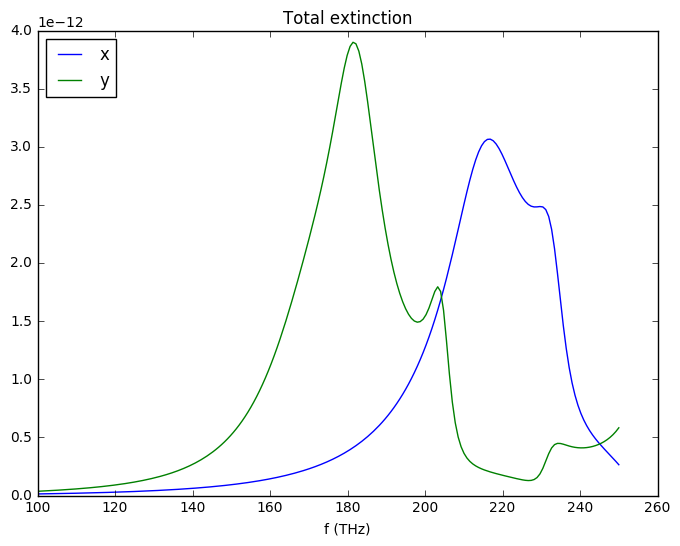

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-12, extinction_x.real, label="x")
plt.plot(freqs*1e-12, extinction_y.real, label="y")
#plt.plot(cst_rcs_x['freq'], cst_rcs_x['rcs']*1e-18, '--', label="cst_x")
#plt.plot(cst_rcs_y['freq'], cst_rcs_y['rcs']*1e-18, '--', label="cst_y")
plt.xlabel("f (THz)")
plt.title("Total extinction")
plt.legend(loc="upper left")
plt.show()

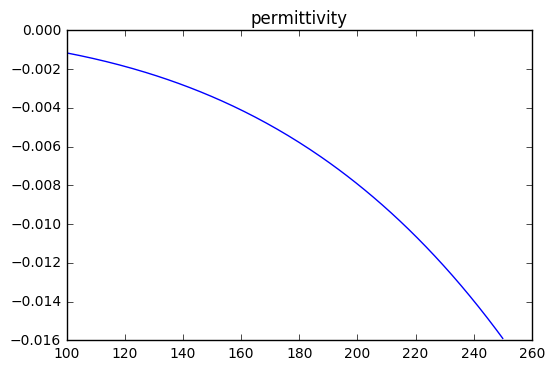

In [13]:
freqs_wide = np.linspace(100e12, 1000e12, 200)

eps = eps_si_green_cst(2j*np.pi*freqs)
plt.figure()
#plt.plot(eps.real)
plt.plot(freqs*1e-12, eps.imag)
plt.title("permittivity")
plt.show()

## Look at multipole decomposition

In [14]:
# Calculate scattering from each multipole
a_ex_scat = np.zeros(a_ex.shape)
a_mx_scat = np.zeros(a_mx.shape)
a_ey_scat = np.zeros(a_ex.shape)
a_my_scat = np.zeros(a_mx.shape)

for l in range(1, num_multipoles+1):
    for m in range(-l, l+1):
#         a_ex_scat[:, l, m] = np.pi/k**2*(2*l+1)*np.abs(a_ex[:, l, m])**2
#         a_mx_scat[:, l, m] = np.pi/k**2*(2*l+1)*np.abs(a_mx[:, l, m])**2
#         a_ey_scat[:, l, m] = np.pi/k**2*(2*l+1)*np.abs(a_ey[:, l, m])**2
#         a_my_scat[:, l, m] = np.pi/k**2*(2*l+1)*np.abs(a_my[:, l, m])**2
        a_ex_scat[:, l, m] = np.pi/k**2*np.abs(a_ex[:, l, m])**2
        a_mx_scat[:, l, m] = np.pi/k**2*np.abs(a_mx[:, l, m])**2
        a_ey_scat[:, l, m] = np.pi/k**2*np.abs(a_ey[:, l, m])**2
        a_my_scat[:, l, m] = np.pi/k**2*np.abs(a_my[:, l, m])**2                

In [15]:
# find total multipole scattering for each polarisation
multipole_scattering_x = np.sum(a_ex_scat+a_mx_scat, axis=(1,2))
multipole_scattering_y = np.sum(a_ey_scat+a_my_scat, axis=(1,2))

In [16]:
fig = go.Figure(data=[{"x": wlen*1e9, "y": multipole_scattering_x/cross_section, "name": "SCS x (multipole)"},
                      {"x": wlen*1e9, "y": extinction_x.real/cross_section, "name": "ECS x (direct)"},
                      {"x": wlen*1e9, "y": multipole_scattering_y/cross_section, "name": "SCS y (multipole)"},
                      {"x": wlen*1e9, "y": extinction_y.real/cross_section, "name": "ECS y (direct)"}
                      ],
               layout = go.Layout(hovermode='closest', title="Compare multipoles with exact solution",
                                   xaxis=go.XAxis(autorange=False, range=[1200, 1800], title="Wavelength (nm)"),
                                   yaxis=go.YAxis(title="scattering")))
ply.iplot(fig)

In [17]:
import itertools

# Take cross-section of each multipole, and put into list of dictionaries for plotly
# For each l, a list of values of m is produced
# itertools.chain is used to join these all into a single list
scat_aex = list(itertools.chain.from_iterable(
        [{"x": wlen*1e9, "y": a_ex_scat[:, l, m]/cross_section, "name": "a_e({},{})".format(l, m)}
                for m in [1]] for l in range(1, 3)))
scat_amx = list(itertools.chain.from_iterable([{"x": wlen*1e9, "y": a_mx_scat[:, l, m]/cross_section,
             "name": "a_m({},{})".format(l, m), "line":{"dash":"dash"}}
                for m in [1]] for l in range(1, 4)))

scat_aey = list(itertools.chain.from_iterable(
        [{"x": wlen*1e9, "y": a_ey_scat[:, l, m]/cross_section, "name": "a_e({},{})".format(l, m)}
                for m in [1]] for l in range(1, 3)))
scat_amy = list(itertools.chain.from_iterable([{"x": wlen*1e9, "y": a_my_scat[:, l, m]/cross_section,
             "name": "a_m({},{})".format(l, m), "line":{"dash":"dash"}}
                for m in [1]] for l in range(1, 4)))


In [18]:
fig = go.Figure(data=scat_aex+scat_amx,
               layout = go.Layout(hovermode='closest', title="Multipole coefficients for x polarisation",
                                   xaxis=go.XAxis(autorange=False, range=[1200, 1800], title="Wavelength (nm)"),
                                  yaxis=go.YAxis(title="scattering")))
ply.iplot(fig)

In [19]:
fig = go.Figure(data=scat_aey+scat_amy,
               layout = go.Layout(hovermode='closest', title="Multipole coefficients for y polarisation",
                                   xaxis=go.XAxis(autorange=False, range=[1200, 2000], title="Wavelength (nm)"),
                                  yaxis=go.YAxis(title="scattering")))
ply.iplot(fig)

## Far field radiation

In [20]:
#cst_bscat_x = pd.read_table("elliptical_rod_bscat_x.txt", skiprows=2, names=['freq', 'bscat'], delim_whitespace=True)
#cst_bscat_y = pd.read_table("elliptical_rod_bscat_y.txt", skiprows=2, names=['freq', 'bscat'], delim_whitespace=True)
#cst_fscat_x = pd.read_table("elliptical_rod_fscat_x.txt", skiprows=2, names=['freq', 'fscat'], delim_whitespace=True)
#cst_fscat_y = pd.read_table("elliptical_rod_fscat_y.txt", skiprows=2, names=['freq', 'fscat'], delim_whitespace=True)

In [21]:
scat_f_x = np.empty(num_freqs)
scat_f_y = np.empty(num_freqs)
scat_b_x = np.empty(num_freqs)
scat_b_y = np.empty(num_freqs)

num_l = a_ex.shape[1]
max_l = num_l-1

l = np.arange(num_l)

k = np.empty_like(freqs)

for freq_count, freq in enumerate(freqs):
    k[freq_count] = 2*np.pi*freq/c

    scat_f_y[freq_count] =  np.abs(sum(sum((2*ln+1)*(a_ey[freq_count, ln, mn] + mn*a_my[freq_count, ln, mn])
                                                for mn in range(-ln, ln+1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4

    scat_f_x[freq_count] =  np.abs(sum(sum((2*ln+1)*(mn*a_ex[freq_count, ln, mn] + a_mx[freq_count, ln, mn])
                                                for mn in range(-ln, ln+1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4
    
    scat_b_y[freq_count] =  np.abs(sum(sum((2*ln+1)*(-1)**ln*(a_ey[freq_count, ln, mn] - mn*a_my[freq_count, ln, mn])
                                            for mn in range(-ln, ln+1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4

    scat_b_x[freq_count] =  np.abs(sum(sum((2*ln+1)*(-1)**ln*(mn*a_ex[freq_count, ln, mn] - a_mx[freq_count, ln, mn])
                                            for mn in range(-ln, ln+1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4
    

In [22]:
fig = go.Figure(data=[{"x": freqs*1e-12, "y": scat_f_x, "name": "Forward (X pol)"},
                      {"x": freqs*1e-12, "y": scat_b_x, "name": "Backward (X pol)"},
                     #{"x": cst_bscat_x['freq'], "y": cst_bscat_x['bscat'], "name":"CST Backward X", "line":{"dash":"dash"}},
                     #{"x": cst_fscat_x['freq'], "y": cst_fscat_x['fscat'], "name":"CST Backward X", "line":{"dash":"dash"}}
                     ],
               layout = go.Layout(hovermode='closest', title="Forward and backward scattering (Y)",
                                   #xaxis=go.XAxis(autorange=False, range=[1200, 1800], title="Wavelength (nm)"),
                                   yaxis=go.YAxis(title="scattering")))
ply.iplot(fig)

In [23]:
fig = go.Figure(data=[{"x": freqs*1e-12, "y": scat_f_y, "name": "Forward (Y pol)"},
                      {"x": freqs*1e-12, "y": scat_b_y, "name": "Backward (Y pol)"},
                      #{"x": cst_bscat_y['freq'], "y": cst_bscat_y['bscat'], "name":"CST Backward Y", "line":{"dash":"dash"}},
                      #{"x": cst_fscat_y['freq'], "y": cst_fscat_y['fscat'], "name":"CST Backward Y", "line":{"dash":"dash"}}
                     ],
               layout = go.Layout(hovermode='closest', title="Forward and backward scattering (X)",
                                   #xaxis=go.XAxis(autorange=False, range=[1200, 1800], title="Wavelength (nm)"),
                                   yaxis=go.YAxis(title="scattering")))
ply.iplot(fig)

## Find modes

In [24]:
contour = ExternalModeContour(-2.5e14+2j*np.pi*300e12, avoid_origin=1e14, overlap_axes=1e11,
                             integration_rule=GaussLegendreRule(80))

estimates = sim.estimate_poles(contour)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [25]:
s_out = list(estimates.modes_of_parts.values())[0]['s_out']

contour_points = np.array([p for p, w in contour])


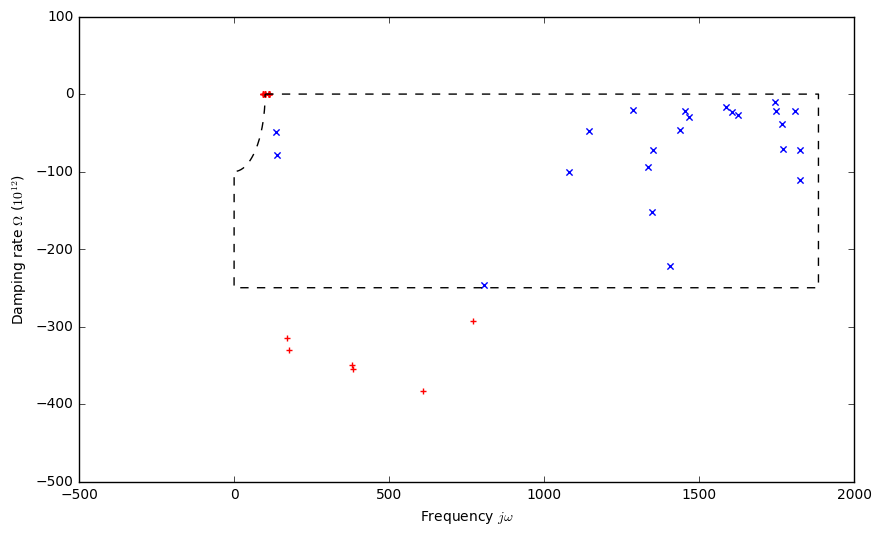

In [26]:
fig = plt.figure(figsize=(10, 6))
points = plt.scatter(estimates.s.imag*1e-12, estimates.s.real*1e-12, marker='x')
plt.scatter(s_out.imag*1e-12, s_out.real*1e-12, marker='+', color='red')
plt.plot(contour_points.imag*1e-12, contour_points.real*1e-12, 'k--')

plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $\Omega$ ($10^{12}$)')

plt.show()

In [27]:
len(estimates)

23

In [28]:
refined = sim.refine_poles(estimates, max_iter=10)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [29]:
len(refined)

22

## Show complex frequencies of modes

In [30]:
refined.s.shape

(1, 22)

In [31]:
# fig = plt.figure(figsize=(10, 6))
# points = plt.scatter(refined.s.imag*1e-14, refined.s.real*1e-14, marker='x')

# labels = ["Mode {0}".format(i) for i in range(len(refined))]
# #tooltip = plugins.PointLabelTooltip(points, labels)
# #plugins.connect(fig, tooltip)
# plt.xlabel('Frequency $j\omega$')
# plt.ylabel('Damping rate $\Omega$')

# plt.show()
# #mpld3.display(fig)

layout = go.Layout(hovermode='closest')
trace = go.Scatter(x = refined.s[0, :].imag*1e-12, y = refined.s[0, :].real*1e-12, 
                   text = ["mode {}".format(mode_num) for mode_num in range(len(refined))],
                   mode='markers')
fig = go.Figure(data=[trace], layout=layout)
ply.iplot(fig)

## Check out the singular value distribution
Gives some indication of how well the contour integration worked

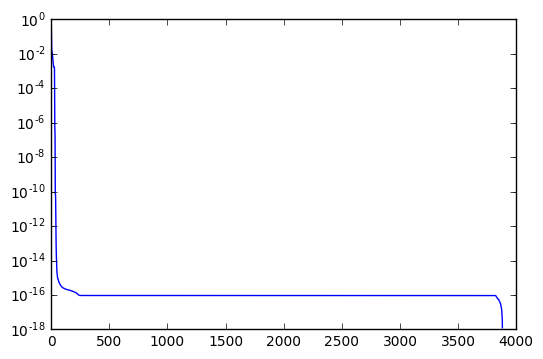

In [32]:
s_vals = estimates.modes_of_parts[sim.parts.unique_id]['C1_S']
plt.figure()
plt.semilogy(s_vals/s_vals[0])
plt.show()

## Plot modes

In [33]:
mode = 5
print(refined.s['modes', mode])
#sim.plot_3d(solution=refined.vr["J", :, 'modes', mode])
#sim.plot_3d(solution=refined.vr[:, :, 'modes', mode], format='vtk', filename='bar.vtp')
#sim.plot_3d(solution=refined.vr[:, :, 'modes', mode], format='vtk', filename='bar.vtp')

(-9.43138898752e+13+1.33497235448e+15j)


In [34]:
full_modes = refined.add_conjugates()

## Calculate extinction by modes

In [35]:
model = ModelMutualWeight(full_modes)

In [36]:
num_modes = len(model.modes)
extinction_modes_x = np.empty((num_freqs, num_modes), np.complex128)
extinction_modes_y = np.empty((num_freqs, num_modes), np.complex128)

vr = model.vr
vl = model.vl

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    # solve for x polarisation
    V = sim.source_vector(pw_x, s)
    V_E = sim.source_vector(pw_x, s, extinction_field=True)   
    I_modes = model.impedance(s).solve(vl.dot(V))
    extinction_modes_x[freq_count] = V_E.vdot(vr*I_modes)
    
    # solve for y polarisation
    V = sim.source_vector(pw_y, s)
    V_E = sim.source_vector(pw_y, s, extinction_field=True)   
    I_modes = model.impedance(s).solve(vl.dot(V))
    extinction_modes_y[freq_count] = V_E.vdot(vr*I_modes)    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Plot extinction as a function of wavelength

In [37]:
# plt.figure()
# plt.plot(wlen*1e9, extinction_x.real/cross_section)
# plt.plot(wlen*1e9, np.sum(extinction_modes_x.real/cross_section, axis=1))
# plt.title("real, x polarised")
# plt.xlim(1200, 1800)
# plt.show()

data=[{"x": wlen*1e9, "y": np.sum(extinction_modes_x.real/cross_section, axis=1), "name": "modes (X pol)"},
      {"x": wlen*1e9, "y": np.sum(extinction_modes_y.real/cross_section, axis=1), "name": "modes (Y pol)"},
      {"x": wlen*1e9, "y": extinction_x.real/cross_section, "name": "exact (X pol)"},
      {"x": wlen*1e9, "y": extinction_y.real/cross_section, "name": "exact (Y pol)"}
     ]
fig = go.Figure(data=data,
                layout = go.Layout(hovermode='closest', title="Total extinction",
                                   xaxis=go.XAxis(autorange=False, range=[1200, 1800], title="Wavelength (nm)"),
                                   yaxis=go.YAxis(title="ECS/D^2")))
ply.iplot(fig)

In [38]:
data=[{"x": wlen*1e9, "y": extinction_modes_x[:, mode_num].real/cross_section, "name": "mode {}".format(mode_num)}
           for mode_num in range(num_modes)]
fig = go.Figure(data=data,layout = go.Layout(hovermode='closest', title="Extinction, X polarisation",
               xaxis=go.XAxis(autorange=False, range=[1200, 1800])))
ply.iplot(fig)

In [39]:
data=[{"x": wlen*1e9, "y": extinction_modes_y[:, mode_num].real/cross_section, "name": "mode {}".format(mode_num)}
           for mode_num in range(num_modes)]
fig = go.Figure(data=data,layout = go.Layout(hovermode='closest', title="Extinction, Y polarisation",
               xaxis=go.XAxis(autorange=False, range=[1200, 2000])))
ply.iplot(fig)

## Inspect the modes which dominate extinction

* short axis, modes 6 and 7 (maybe 11)
* long axis, modes 2 and 3 (maybe 4)

In [54]:
mode=4
sim.plot_3d(solution=refined.vr["J", :, 'modes', mode])

## Save results

In [46]:
vars_to_save = ["freqs", "refined", "parameters", "sim", 
                "extinction_x", "extinction_modes_x", "extinction_y", "extinction_modes_y",
                "a_ex", "a_mx", "a_ey", "a_my", "contour"]

results = dict((var, globals()[var]) for var in vars_to_save)

import dill as pickle

with open("elliptical_cylinder_calculations.pickle", "wb") as outfile:
    pickle.dump(results, outfile)